# Project Briefing

This notebook intends to build a classification model that categorizes wine reviews according to their grape varieties. It does so by using NLTK and a deep neural network. 

## Dataset

The dataset consists of wine reviews from the website Wine Enthusiast. The data contains information such as the geographical origin, the variety, and price of each wine.
https://www.kaggle.com/zynicide/wine-reviews
https://www.kaggle.com/zynicide/wine-reviews/discussion/83970
https://www.kaggle.com/manyregression/updated-wine-enthusiast-review


## Libraries

In [1]:
import pandas as pd
import numpy as np
import string

import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model
from keras.utils import to_categorical
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn import tree
from sklearn.metrics import roc_curve, auc,  confusion_matrix, classification_report 
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer

from unidecode import unidecode
from scipy.sparse import csr_matrix

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline

Using TensorFlow backend.


# Loading and exploring data

In [14]:
# loads files

# https://www.kaggle.com/zynicide/wine-reviews/discussion/83970
df_1 = pd.read_csv('data\winemag-data-190314.csv', index_col=0).reset_index(drop=True)

# https://www.kaggle.com/manyregression/updated-wine-enthusiast-review
df_2 = pd.read_csv('data\winemag-data-2017-2020.csv').reset_index(drop=True) 

df = pd.concat([df_2, df_1]).reset_index(drop=True)
del df_1, df_2
df.dropna(axis=0, how='any', subset=['description', 'variety'], inplace=True)

# removes "blend" varieties 
blend_filt = df['variety'].str.contains('Blend')
df.drop(index=df.loc[blend_filt].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [15]:
df.head()

country                                        description  \
0  Portugal  This is a deliciously creamy wine with light w...   
1        US  Black plum juice, black pepper, caramel and sm...   
2   Georgia  Aromas of green apple and white flowers prepar...   
3    Kosovo  This wine has aromas of black berry, dried red...   
4     Italy  A blend of organically cultivated Groppello, M...   

              designation  points  price         province     region_1  \
0          Assobio Branco      87   14.0            Douro          NaN   
1                     NaN      87   25.0       California  Paso Robles   
2                     NaN      87   14.0        Lechkhumi          NaN   
3                     NaN      87   13.0  Rahoveci Valley          NaN   
4  San'Emiliano Chiaretto      87   13.0         Lombardy    Valtènesi   

        region_2    taster_name  \
0            NaN     Roger Voss   
1  Central Coast  Matt Kettmann   
2            NaN  Mike DeSimone   
3            NaN   Jeff Jenssen   
4            NaN  Kerin O’Keefe   

                                        taster_photo taster_twitter_handle  \
0  https://253qv1sx4ey389p9wtpp9sj0-wpengine.netd...            @vossroger   
1  https://253qv1sx4ey389p9wtpp9sj0-wpengine.netd...         @mattkettmann   
2  https://253qv1sx4ey389p9wtpp9sj0-wpengine.netd...        @worldwineguys   
3  https://253qv1sx4ey389p9wtpp9sj0-wpengine.netd...        @worldwineguys   
4  https://253qv1sx4ey389p9wtpp9sj0-wpengine.netd...          @kerinokeefe   

                                               title             variety  \
0  Quinta dos Murças 2016 Assobio Branco White (D...    Portuguese White   
1  Western Slope 2014 Cabernet Sauvignon (Paso Ro...  Cabernet Sauvignon   
2         Teliani Valley 2015 Tsolikouri (Lechkhumi)          Tsolikouri   
3         Stone Castle 2013 Shiraz (Rahoveci Valley)              Shiraz   
4  Pratello 2016 San'Emiliano Chiaretto Rosato (V...              Rosato   

  vintage             winery  
0    2016  Quinta dos Murças  
1    2014      Western Slope  
2    2015     Teliani Valley  
3    2013       Stone Castle  
4    2016           Pratello

In [16]:
df.shape

(176987, 15)

In [18]:
df['variety'].nunique()

840

In [17]:
df['variety'].value_counts()

Pinot Noir                        23739
Chardonnay                        19156
Cabernet Sauvignon                15235
Riesling                           8693
Sauvignon Blanc                    8364
Rosé                               7440
Syrah                              6569
Nebbiolo                           5137
Sangiovese                         4835
Merlot                             4472
Portuguese Red                     4349
Zinfandel                          4247
Malbec                             4229
Tempranillo                        3099
Gamay                              2574
Cabernet Franc                     2426
Pinot Gris                         2423
Grüner Veltliner                   2344
Portuguese White                   2077
Viognier                           1642
Gewürztraminer                     1610
Pinot Grigio                       1563
Shiraz                             1462
Grenache                           1399
Petite Sirah                       1322


## Wine Varieties

In [5]:
# stores all varieties so that they are treated as stopswords later on
all_varieties = list(df['variety'].unique())

# stores varieties with at least 1000 reviews
filt = df['variety'].value_counts() > 1000
varieties_above_threshold = [variety for variety in filt.index if filt[variety]]
del filt

# drop varieties with less then 1000 reviews
varieties_filt = df['variety'].isin(varieties_above_threshold)
df = df.loc[varieties_filt, ['description', 'variety']]
df.reset_index(inplace=True, drop=True)

Text(0.5, 0, 'varieties')

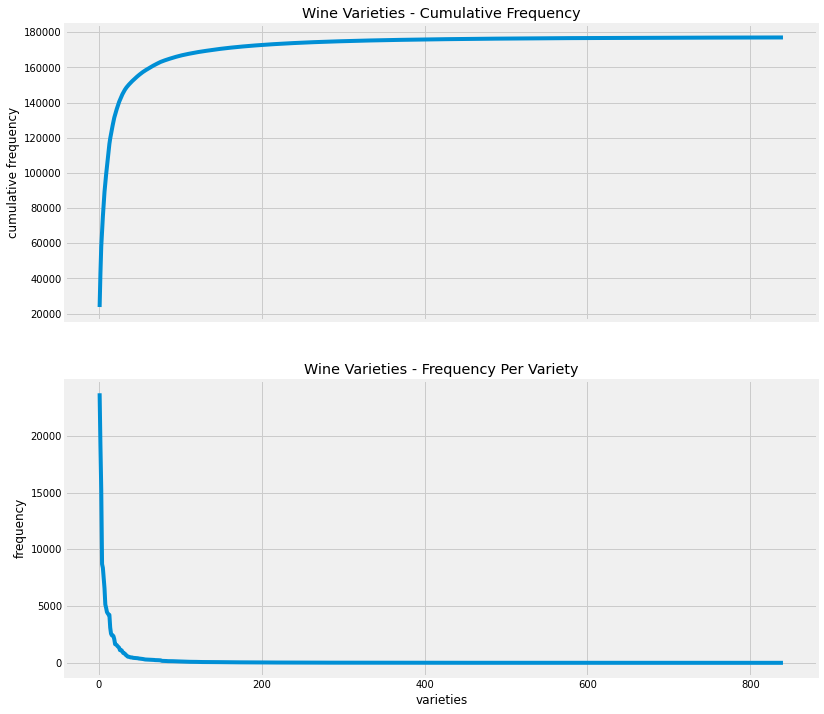

In [22]:
wine_varieties_df = pd.DataFrame(df['variety'].value_counts())

max_ = wine_varieties_df['variety'].cumsum().max()

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

ax1.plot(range(1, len(wine_varieties_df.cumsum())+1), (wine_varieties_df['variety'].cumsum()))
ax1.set_title('Wine Varieties - Cumulative Frequency')
ax1.set_ylabel('cumulative frequency')

y = wine_varieties_df
x = range(1, len(y)+1)
ax2.plot(x, y)
ax2.set_title('Wine Varieties - Frequency Per Variety')
ax2.set_ylabel('frequency')
ax2.set_xlabel('varieties')

## Descriptions

mean:  40.419763307845905
std:  11.417724845998151


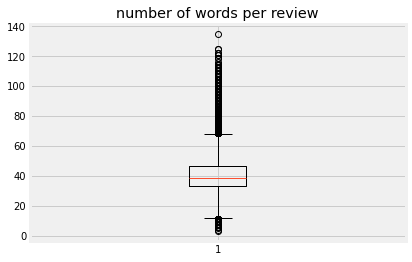

In [7]:
# n of words in each description
n_words_list = [len(text) for text in df['description'].str.split()]
mean_ = np.mean(n_words_list)
std_ = np.std(n_words_list)
print('mean: ', mean_)
print('std: ', std_)
plt.boxplot(n_words_list)
plt.title('number of words per review')
plt.show()

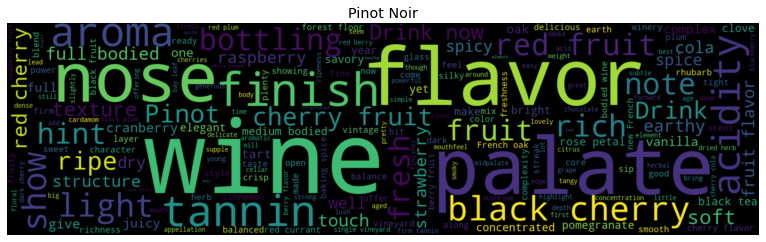

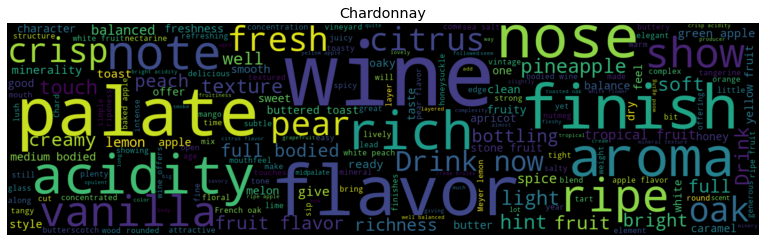

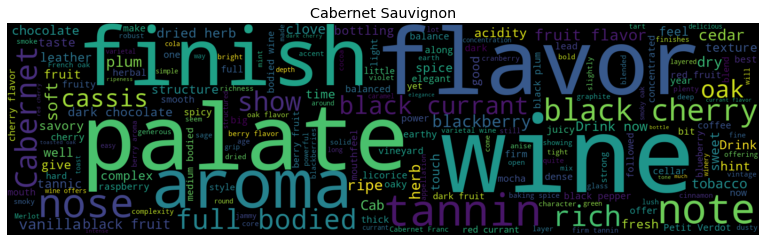

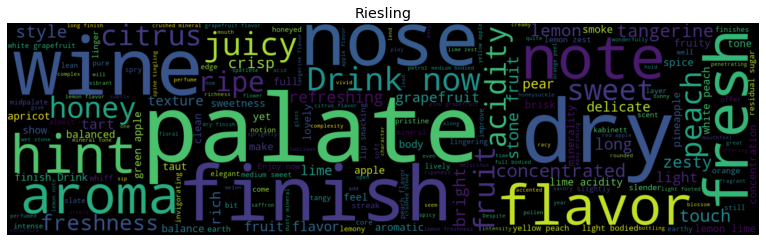

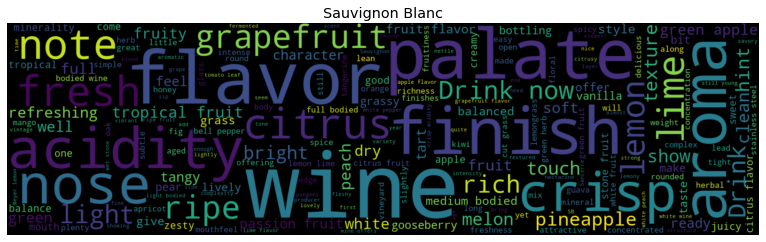

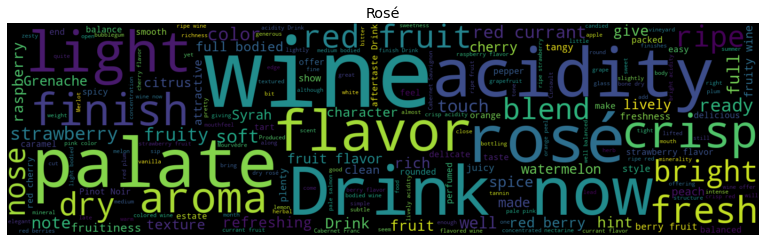

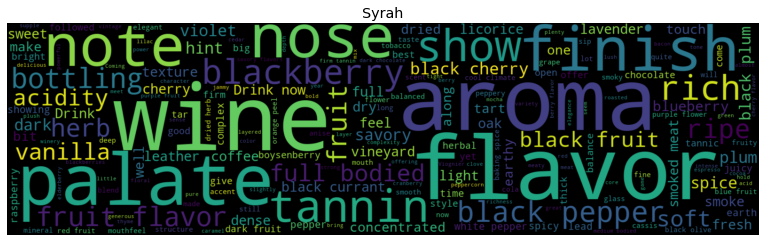

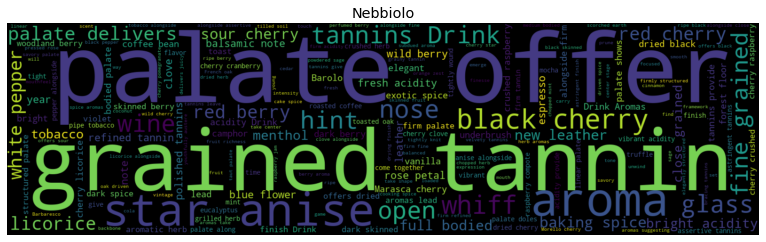

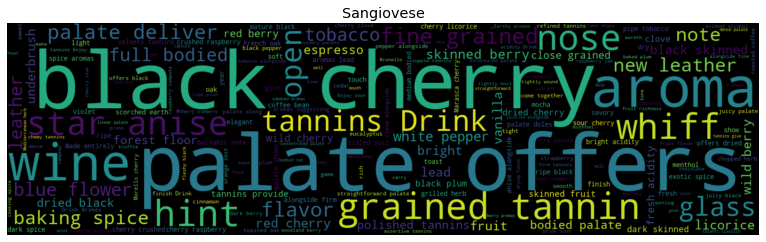

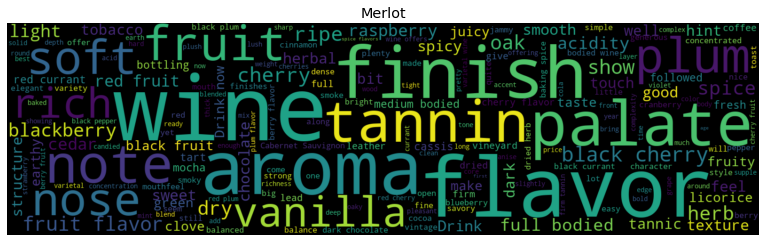

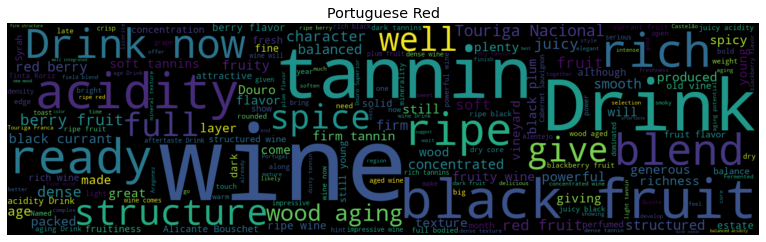

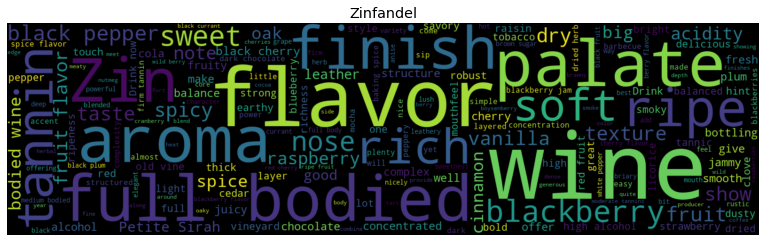

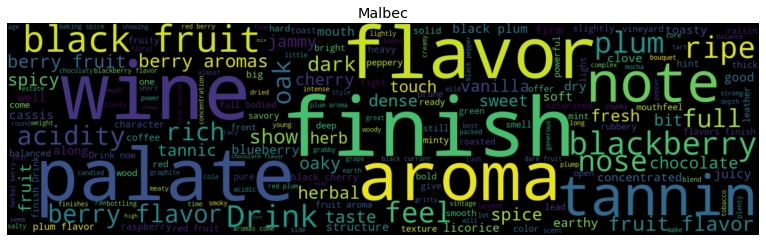

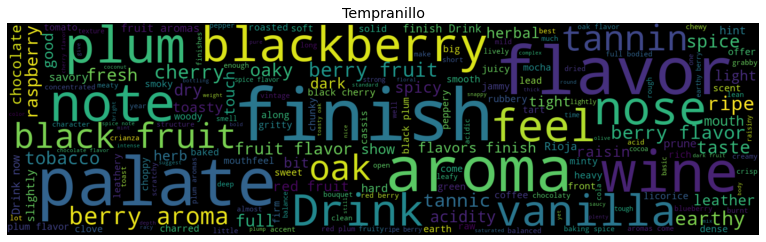

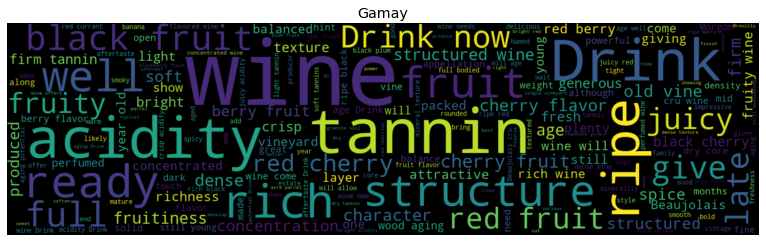

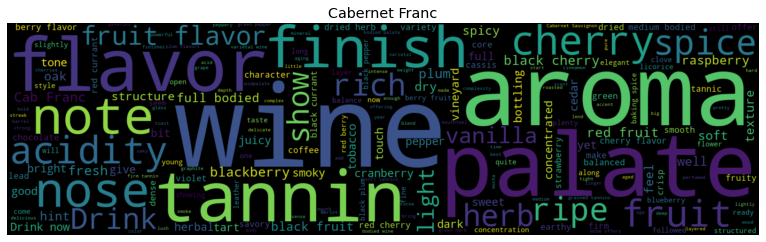

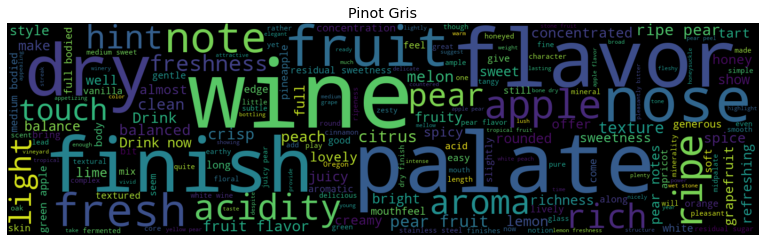

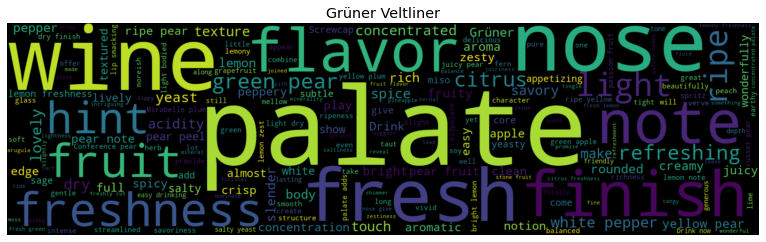

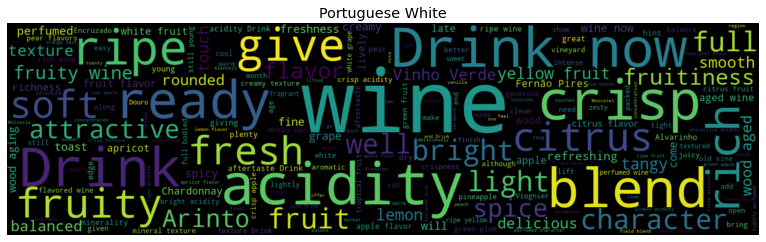

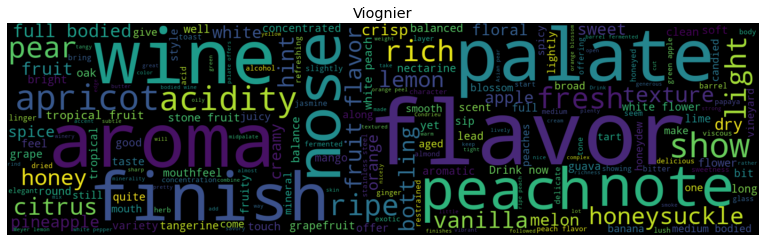

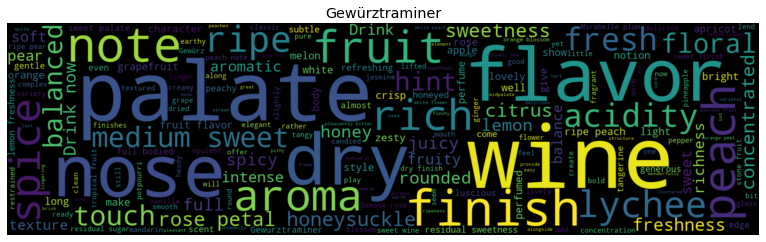

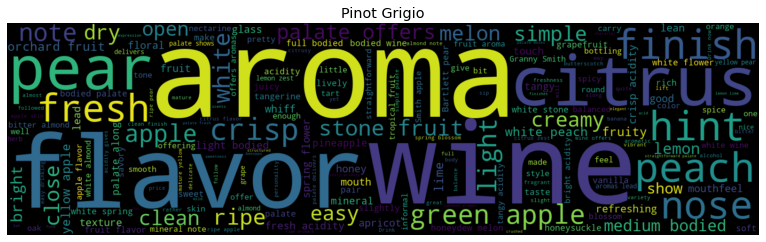

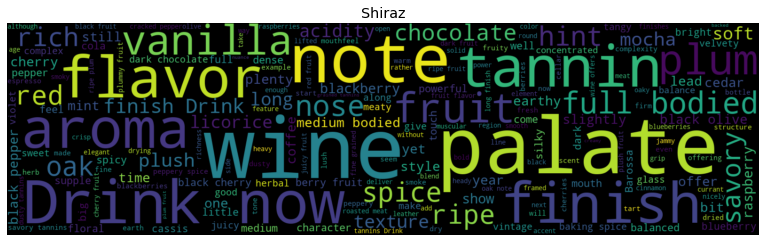

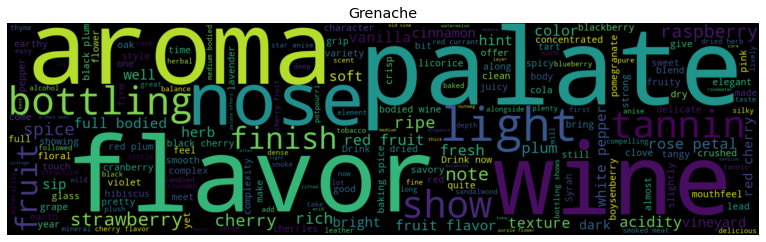

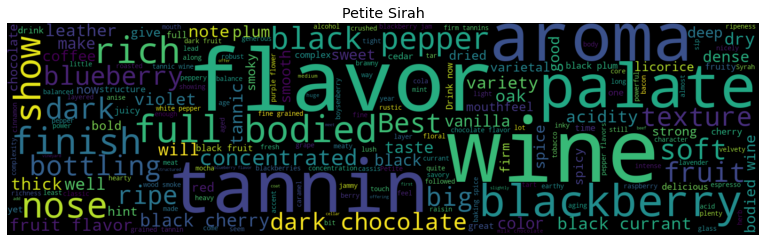

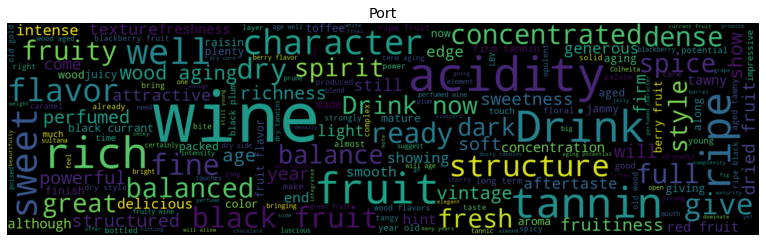

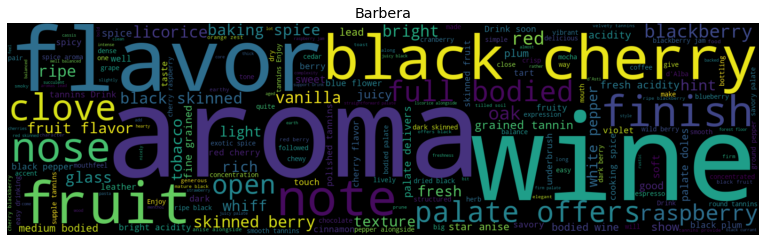

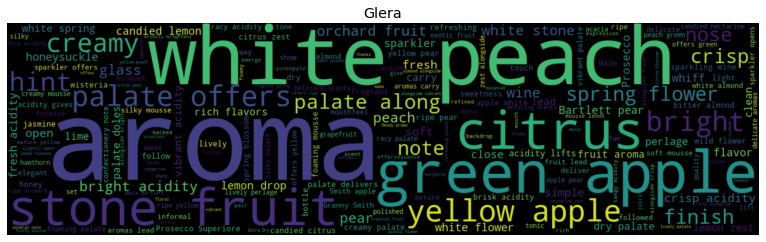

In [40]:
word_clouds_dict = dict()
for variety in varieties_above_threshold:
    var_filt = df['variety'] == variety
    concat_texts = " ".join(df.loc[var_filt, 'description']).replace(variety, "")
    wordcloud = WordCloud(width=1600, 
                          height=450).generate(concat_texts)
    word_clouds_dict[variety] = wordcloud
    
n = len(varieties_above_threshold)

# Display the generated image:
for key in word_clouds_dict.keys():
    f = plt.figure(figsize=(12, 6))
    plt.imshow(word_clouds_dict[key], interpolation='bilinear')
    plt.title(str(key))
    plt.axis("off")
    plt.show()

## Class imbalance

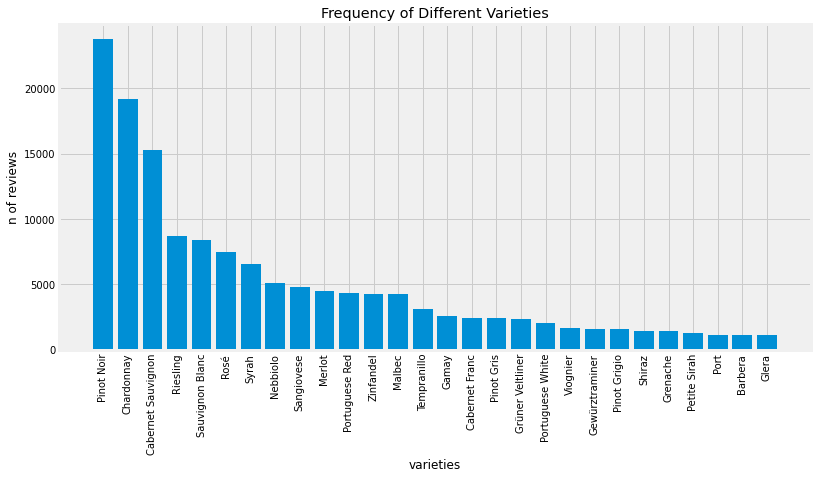

In [47]:
plt.figure(figsize=(12, 6))
plt.bar(pd.DataFrame(df['variety'].value_counts()).index,
        pd.Series(df['variety'].value_counts()).values)
plt.title('Frequency of Different Varieties')
plt.xlabel('varieties')
plt.xticks(rotation=90)
plt.ylabel('n of reviews')
plt.show()

## Vectorization

In [8]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# Now we have a list that includes all english stopwords, ponctuation and wine varieties
stopwords_list += list(string.punctuation)
stopwords_list += [unidecode(v.lower()) for v in all_varieties]

In [9]:
filt = df['variety'].isin(varieties_above_threshold)
X = df.loc[filt, 'description']
Y = df.loc[filt, 'variety'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [50]:
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                   stop_words=stopwords_list,
                                   strip_accents='unicode',
                                   min_df= 100)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Classification Models

## Logistic Regression

To be seen as a benchmark for the Neural Network

In [52]:
clf_lr = LogisticRegression(random_state=42)

clf_lr.fit(X_train_tfidf, y_train)

print('train:', clf_lr.score(X_train_tfidf, y_train))
print('test:', clf_lr.score(X_test_tfidf, y_test))

train: 0.692081382751389
test: 0.6505797773654917


## Neural Network

In [53]:
smot = SMOTE(k_neighbors=3, random_state=42)
X_train_tfidf_over, y_train_over = smot.fit_sample(X_train_tfidf, y_train)

train_labels = to_categorical(y_train_over) ##
test_labels = to_categorical(y_test)

nor = Normalizer()
X_train_scaled = nor.fit_transform(X_train_tfidf_over)
X_test_scaled = nor.transform(X_test_tfidf)

In [54]:

n_features = int(X_train_tfidf.shape[-1])
print('n_features: ',n_features)



early_stopping = [EarlyStopping(monitor='val_loss', patience=20), 
                  ModelCheckpoint(filepath='model_v1.h5', monitor='val_loss', save_best_only=True)
                 ]


lambda_coeff = 0.01 

# network architecture
model = models.Sequential()

# add layers 
# (in this case, Dense which means that this layer will be fully connected)
# input_shape parameter is often optiona
model.add(layers.Dense(1000, 
                       kernel_initializer='lecun_normal',
                       activation='relu',
                       input_shape=(n_features,)))
kernel_regularizer=regularizers.l2(lambda_coeff)
model.add(layers.Dropout(0.3))

model.add(layers.Dense(300, 
                       kernel_initializer='lecun_normal',
                       activation='relu'))
model.add(layers.Dropout(0.3))
#kernel_regularizer=regularizers.l2(lambda_coeff)

model.add(layers.Dense(75, 
                       kernel_initializer='lecun_normal',
                       activation='relu'))
model.add(layers.Dropout(0.3))
# kernel_regularizer=regularizers.l2(lambda_coeff)

model.add(layers.Dense(len(varieties_above_threshold), 
                       activation='softmax'))


# compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model
# batched size can be tuned. The model will forward and backwards propagate once per batch
history = model.fit(X_train_scaled, train_labels,
                    epochs=300,
                    batch_size=500,
                    validation_split=0.35,
                   callbacks=early_stopping)


n_features:  2237
Train on 301592 samples, validate on 162396 samples
Epoch 1/300
301592/301592 [==============================] - 92s 305us/step - loss: 1.0735 - acc: 0.6859 - val_loss: 2.1126 - val_acc: 0.3134
Epoch 2/300
301592/301592 [==============================] - 91s 301us/step - loss: 0.4771 - acc: 0.8595 - val_loss: 1.4177 - val_acc: 0.4830
Epoch 3/300
301592/301592 [==============================] - 91s 301us/step - loss: 0.2942 - acc: 0.9119 - val_loss: 0.8592 - val_acc: 0.6867
Epoch 4/300
301592/301592 [==============================] - 93s 308us/step - loss: 0.2039 - acc: 0.9381 - val_loss: 0.6021 - val_acc: 0.7854
Epoch 5/300
301592/301592 [==============================] - 91s 302us/step - loss: 0.1477 - acc: 0.9551 - val_loss: 0.3839 - val_acc: 0.8703
Epoch 6/300
301592/301592 [==============================] - 92s 306us/step - loss: 0.1108 - acc: 0.9660 - val_loss: 0.2184 - val_acc: 0.9329
Epoch 7/300
301592/301592 [==============================] - 92s 306us/step - 

Epoch 58/300
301592/301592 [==============================] - 90s 297us/step - loss: 0.0076 - acc: 0.9977 - val_loss: 0.0040 - val_acc: 0.9989
Epoch 59/300
301592/301592 [==============================] - 86s 287us/step - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0031 - val_acc: 0.9992
Epoch 60/300
301592/301592 [==============================] - 90s 300us/step - loss: 0.0079 - acc: 0.9976 - val_loss: 0.0033 - val_acc: 0.9993
Epoch 61/300
301592/301592 [==============================] - 87s 289us/step - loss: 0.0075 - acc: 0.9977 - val_loss: 0.0037 - val_acc: 0.9992
Epoch 62/300
301592/301592 [==============================] - 89s 296us/step - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0029 - val_acc: 0.9993
Epoch 63/300
301592/301592 [==============================] - 89s 294us/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0035 - val_acc: 0.9991
Epoch 64/300
301592/301592 [==============================] - 92s 305us/step - loss: 0.0078 - acc: 0.9977 - val_loss: 0.0057 - val_acc: 0.9985

In [55]:
print('train:', model.evaluate(X_train_scaled, train_labels))
print('test:', model.evaluate(X_test_scaled, test_labels))    

model.summary()

463988/463988 [==============================] - 103s 222us/step
train: [0.0016170701393246304, 0.9995991275636439]
43120/43120 [==============================] - 8s 188us/step
test: [2.353562894336368, 0.7209879406307977]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              2238000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               300300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 75)                22575     
___________________________________________________

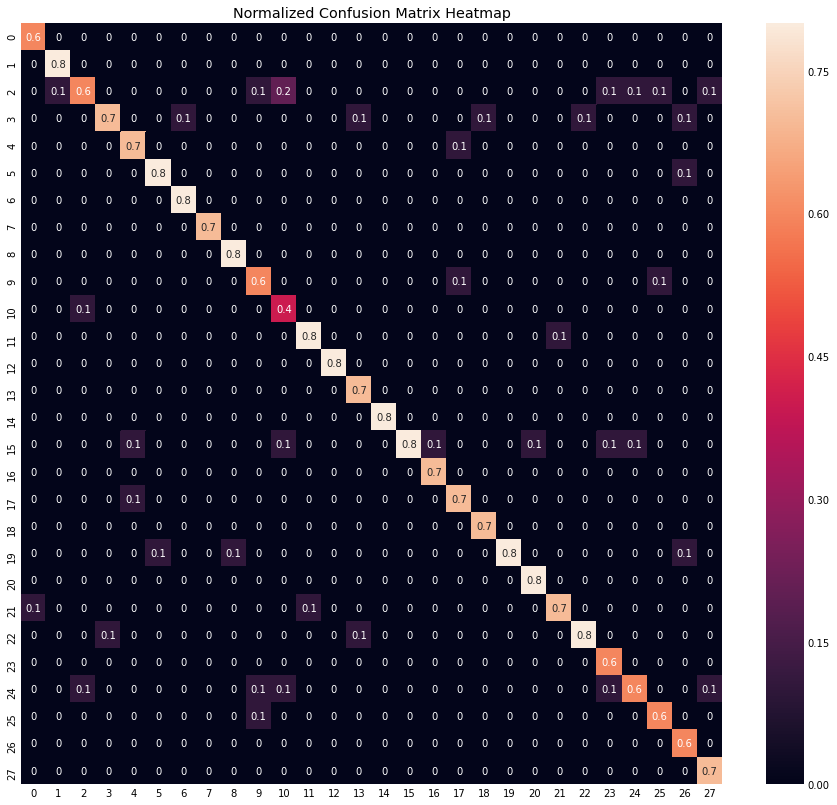

In [74]:
# confusion matrix
y_test_pred = model.predict(X_test_scaled)
matrix = confusion_matrix(test_labels.argmax(axis=1), y_test_pred.argmax(axis=1))
plt.figure(figsize=(14,14))
sns.heatmap(np.around((matrix/sum(matrix)), decimals=1), annot=True)
plt.title('Normalized Confusion Matrix Heatmap')
plt.show()


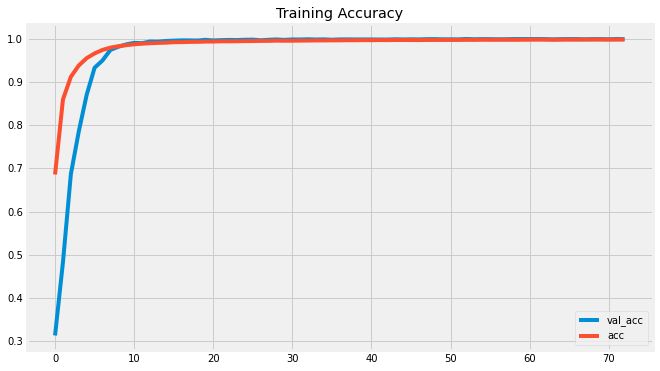

In [59]:
f = plt.figure(figsize=(10, 6))
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.plot(history.history['acc'],  label='acc')
plt.legend()
plt.title('Training Accuracy')
plt.show()

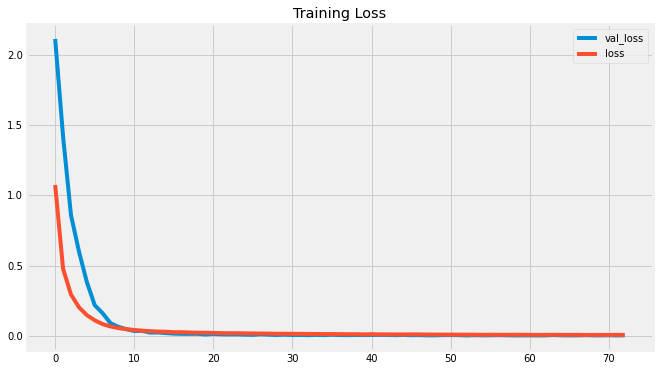

In [60]:
f = plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.plot(history.history['loss'],  label='loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [62]:

# more matrixs (recall, precision, etc)
clf_report = classification_report(test_labels.argmax(axis=1), y_test_pred.argmax(axis=1))
print(clf_report)

              precision    recall  f1-score   support

           0       0.64      0.47      0.54       309
           1       0.76      0.48      0.59       739
           2       0.64      0.72      0.68      4492
           3       0.75      0.89      0.81      5732
           4       0.73      0.66      0.69       795
           5       0.79      0.57      0.66       505
           6       0.84      0.89      0.87       304
           7       0.70      0.34      0.46       434
           8       0.84      0.77      0.80       689
           9       0.58      0.45      0.50      1251
          10       0.42      0.35      0.38      1338
          11       0.84      0.82      0.83      1557
          12       0.76      0.46      0.57       406
          13       0.72      0.63      0.67       474
          14       0.78      0.58      0.67       744
          15       0.77      0.85      0.81      7168
          16       0.73      0.68      0.70       342
          17       0.73    

In [ ]:
# model.save('model1.h5')